In [9]:
%matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

from datetime import date


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [10]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [11]:
# Get case data
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

dfCase = pd.read_csv(latestdir+'/Kommunalt_DB/07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv',encoding='latin1',delimiter=';')
dfCase['Dato'] = pd.to_datetime(dfCase['Dato'])

In [12]:
# Get case data
latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfCase2 = pd.read_csv(latestdir+'/Municipality_cases_time_series.csv',delimiter=';')
dfCase2['SampleDate'] = pd.to_datetime(dfCase2['SampleDate'])
dfCase2['Dato'] = pd.to_datetime(dfCase2['SampleDate'])

In [13]:
# Get test data
latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfTest = pd.read_csv(latestdir+'/Municipality_tested_persons_time_series.csv',delimiter=';')
dfTest['PrDate_adjusted'] = pd.to_datetime(dfTest['PrDate_adjusted'])
dfTest['Dato'] = pd.to_datetime(dfTest['PrDate_adjusted'])
# dfTest

In [14]:

latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir
dfKort = pd.read_csv(latestdir+'/Kommunalt_DB/10_Kommune_kort.csv',encoding='latin1',delimiter=';')
# dfKort['Dato'] = pd.to_datetime(dfKort['Dato'])
def getPopCount(komNavn):
    return int(dfKort[dfKort['Kommunenavn'] == komNavn]['Antal borgere'].iloc[0])
# getPopCount('København') - 93000

In [15]:
dateRange = dfTest.Dato 
datedf = pd.DataFrame({'Dato':dateRange})

dfCase2 = dfCase2.merge(datedf,on='Dato',how='right')
dfCase2 = dfCase2.iloc[:,1:-1].fillna(0)
# dfCase2


In [16]:
# firstDate = np.datetime64('2020-03-16')

# dfTest = dfTest[dfTest.Dato >= firstDate]
# dfCase2 = dfCase2[dfCase2.SampleDate >= firstDate]
# dfCase = dfCase[dfCase.Dato >= firstDate]
# # dfTest = dfTest[dfTest.Dato >= firstDate]



# dfTest = dfTest[dfTest.Dato <= np.datetime64('2022-02-28')]
# dfCase2 = dfCase2[dfCase2.SampleDate <= np.datetime64('2022-02-28')]
# dfCase = dfCase[dfCase.Dato <= np.datetime64('2022-02-28')]

In [17]:
dfTest['København'] = dfTest['Copenhagen']
dfCase2['København'] = dfCase2['Copenhagen']

In [18]:

curKom = 'Norddjurs'
curKom = 'København'
# curKom = 'Aalborg'
# curKom = 'Roskilde'

curCase = dfCase[dfCase.Kommunenavn == curKom]['Bekræftede tilfælde i alt'].values
curdfcase = dfCase[dfCase.Kommunenavn == curKom].merge(datedf,on='Dato',how='right')
curCase = curdfcase['Bekræftede tilfælde i alt'].fillna(0)
curCaseNew = dfCase2[curKom].values
curTest = dfTest[curKom]


# curCase = dfCase[dfCase.Kommunenavn == 'Ishøj']['Bekræftede tilfælde i alt'].values
# curCaseNew = dfCase2['Ishøj'].values
# curTest = dfTest['Ishøj']

curPos = curCase/curTest 
curDates = dfTest.Dato


# curCase = dfCase[dfCase.Kommunenavn == 'København']['Bekræftede tilfælde i alt']
# curCaseNew = dfCase2['Copenhagen'].values[-len(curCase):]
# curTest = dfTest.Copenhagen.values[-len(curCase):]
# curPos = curCase/curTest 
# curDates = dfTest.Dato.values[-len(curCase):]


In [19]:
# Functions

reInf = curCase-curCaseNew 


def reinfOfAllBefore(changeDate):
    # changeDate = np.datetime64('2021-10-01')
    changeIndex = np.where(curDates==changeDate)[0][0]

    cuRe = np.cumsum(reInf).values 
    cuNew = np.cumsum(curCaseNew)

    reTot = cuRe[-1] - cuRe[changeIndex]
    caseBefore = cuNew[changeIndex]
    return reTot/caseBefore

    # # popCount = getPopCount(curKom)
    # reTot = np.sum(reInf) - np.cumsum(reInf)[changeIndex]
    # caseBefore = np.cumsum(curCase)[changeIndex]
    # return reTot/caseBefore
     
def newInfAfter(changeDate):
    changeIndex = np.where(curDates==changeDate)[0][0]
    popCount = getPopCount(curKom)

    cuNew = np.cumsum(curCaseNew)
    
    caseBefore = cuNew[changeIndex]
    ratioBefore = caseBefore/popCount 

    caseAfter = cuNew[-1]-caseBefore
    ratioAfter = caseAfter/popCount 

    return ratioAfter




reinfOfAllBefore(np.datetime64('2021-10-01'))
newInfAfter(np.datetime64('2021-10-01'))


0.4041909635756739

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\2104734942.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\2104734942.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\2104734942.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\2104734942.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\2104734942.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore


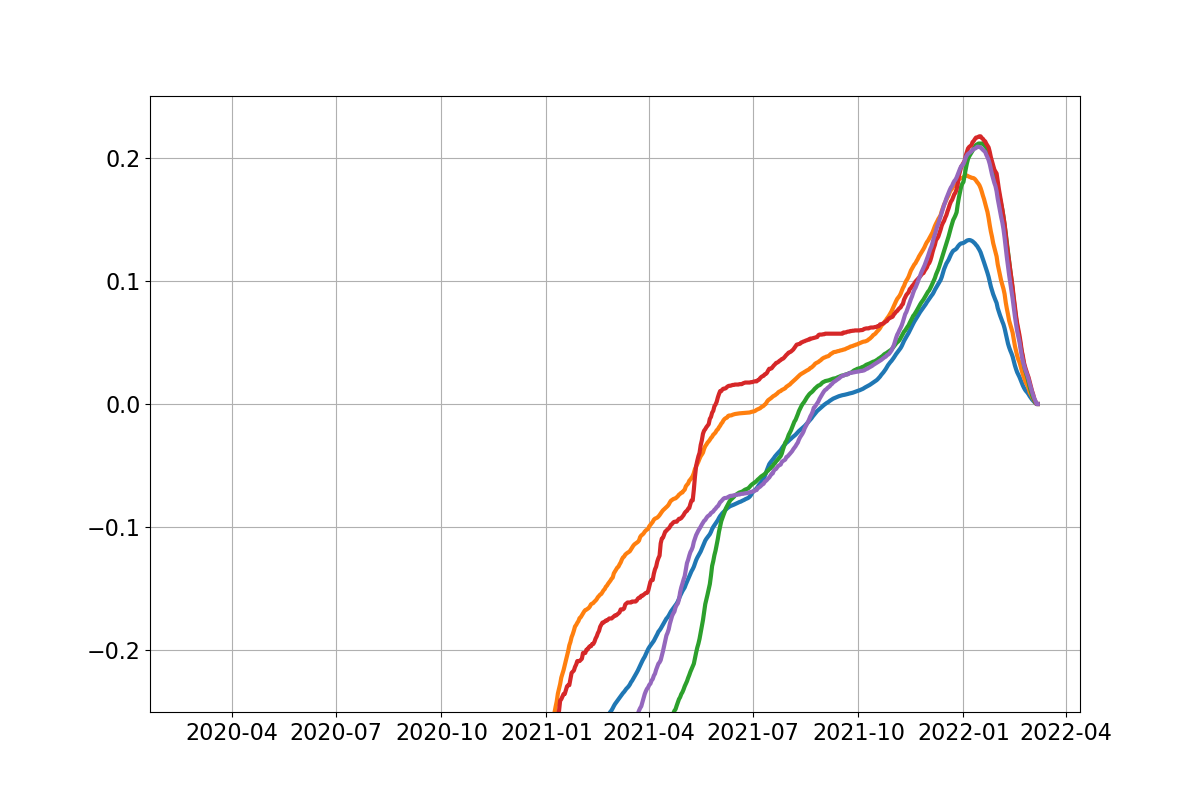

In [78]:
def getEqualDate(curKom):
    
    curCase = dfCase[dfCase.Kommunenavn == curKom]['Bekræftede tilfælde i alt'].values
    curdfcase = dfCase[dfCase.Kommunenavn == curKom].merge(datedf,on='Dato',how='right')
    curCase = curdfcase['Bekræftede tilfælde i alt'].fillna(0)
    curCaseNew = dfCase2[curKom].values
    curTest = dfTest[curKom]
    curPos = curCase/curTest 
    curDates = dfTest.Dato

    reInfBefores = np.zeros(len(curDates))
    infAfters = np.zeros(len(curDates))

    reInf = curCase-curCaseNew 

    # for changeDate in curDates:
    for i,changeDate in enumerate(curDates):
        changeIndex = np.where(curDates==changeDate)[0][0]

        cuRe = np.cumsum(reInf).values 
        cuNew = np.cumsum(curCaseNew)

        reTot = cuRe[-1] - cuRe[changeIndex]
        caseBefore = cuNew[changeIndex]
        
        changeIndex = np.where(curDates==changeDate)[0][0]
        popCount = getPopCount(curKom)

        cuNew = np.cumsum(curCaseNew)
        
        caseBefore = cuNew[changeIndex]
        ratioBefore = caseBefore/popCount 

        caseAfter = cuNew[-1]-caseBefore
        ratioAfter = caseAfter/popCount 

        reInfBefores[i] = reTot/caseBefore
        infAfters[i] = ratioAfter
    return reInfBefores,infAfters
    # return curDates[np.argmin(np.abs(infAfters[50:-50]-reInfBefores[50:-50]))]


    # reInfBefores = np.array([reinfOfAllBefore(x) for x in curDates])
    # infAfters  = np.array([newInfAfter(x) for x in curDates])

# getEqualDate('København')

plt.figure() 
reInfBefores,infAfters = getEqualDate('København')
plt.plot(curDates,infAfters-reInfBefores)
reInfBefores,infAfters = getEqualDate('Roskilde')
plt.plot(curDates,infAfters-reInfBefores)
reInfBefores,infAfters = getEqualDate('Aalborg')
plt.plot(curDates,infAfters-reInfBefores)
reInfBefores,infAfters = getEqualDate('Norddjurs')
plt.plot(curDates,infAfters-reInfBefores)
reInfBefores,infAfters = getEqualDate('Horsens')
plt.plot(curDates,infAfters-reInfBefores)
plt.ylim([-0.25,0.25])
plt.grid()


In [79]:
def getEqualDate(curKom):
    
    curCase = dfCase[dfCase.Kommunenavn == curKom]['Bekræftede tilfælde i alt'].values
    curdfcase = dfCase[dfCase.Kommunenavn == curKom].merge(datedf,on='Dato',how='right')
    curCase = curdfcase['Bekræftede tilfælde i alt'].fillna(0)
    curCaseNew = dfCase2[curKom].values
    curTest = dfTest[curKom]
    curPos = curCase/curTest 
    curDates = dfTest.Dato

    reInfBefores = np.zeros(len(curDates))
    infAfters = np.zeros(len(curDates))

    reInf = curCase-curCaseNew 
    
    # for changeDate in curDates:
    for i,changeDate in enumerate(curDates):
        changeIndex = np.where(curDates==changeDate)[0][0]

        cuRe = np.cumsum(reInf).values 
        cuNew = np.cumsum(curCaseNew)

        reTot = cuRe[-1] - cuRe[changeIndex]
        caseBefore = cuNew[changeIndex]
        
        changeIndex = np.where(curDates==changeDate)[0][0]
        popCount = getPopCount(curKom)

        cuNew = np.cumsum(curCaseNew)
        
        caseBefore = cuNew[changeIndex]
        ratioBefore = caseBefore/popCount 

        caseAfter = cuNew[-1]-caseBefore
        ratioAfter = caseAfter/popCount 

        reInfBefores[i] = reTot/caseBefore
        infAfters[i] = ratioAfter

    return curDates[np.argmin(np.abs(infAfters[50:-50]-reInfBefores[50:-50]))]


    # reInfBefores = np.array([reinfOfAllBefore(x) for x in curDates])
    # infAfters  = np.array([newInfAfter(x) for x in curDates])

getEqualDate('København')

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore


Timestamp('2021-07-14 00:00:00')

In [80]:
reInfBefores = np.array([reinfOfAllBefore(x) for x in curDates])
infAfters  = np.array([newInfAfter(x) for x in curDates])


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\1927764970.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return reTot/caseBefore


In [81]:
np.argmin(np.abs(infAfters[50:]-reInfBefores[50:]))
curDates[697]

Timestamp('2022-01-15 00:00:00')

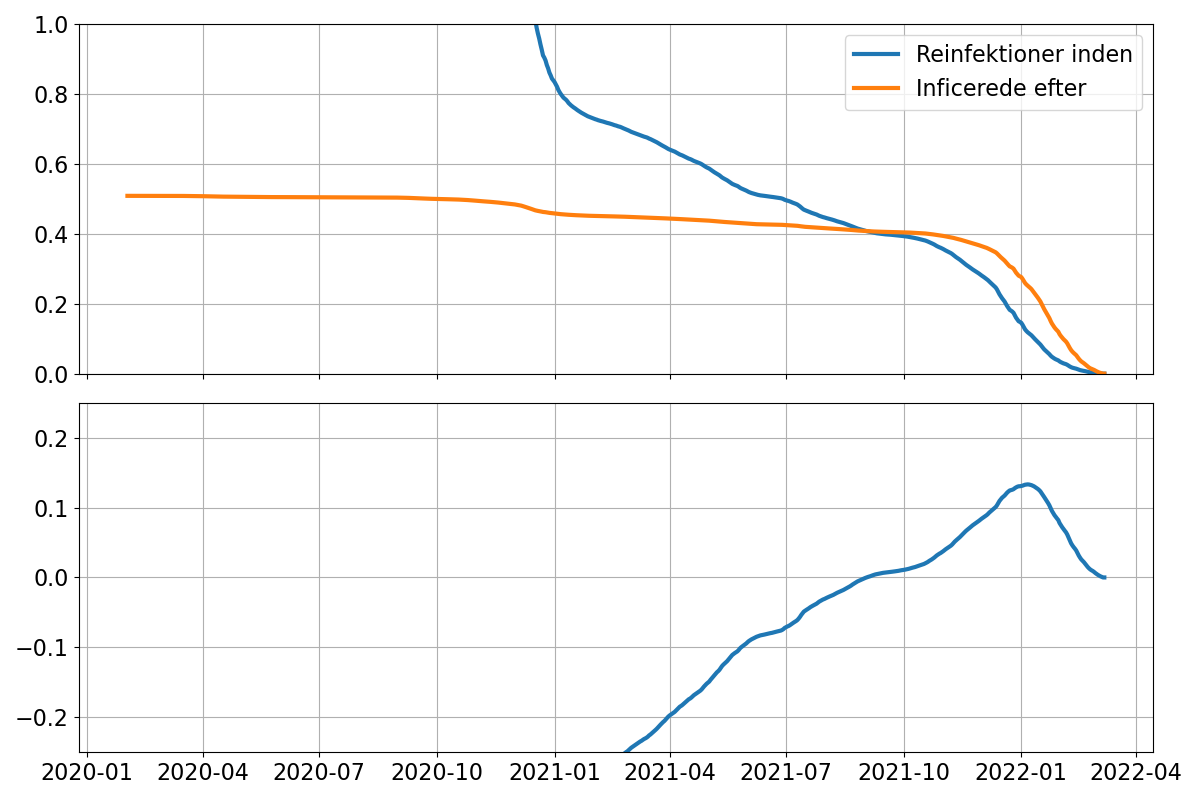

In [82]:
# fig,ax1 = plt.subplots() 
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True) 

ax1.plot(curDates,reInfBefores,label='Reinfektioner inden')
ax1.plot(curDates,infAfters,label='Inficerede efter')

ax2.plot(curDates,infAfters-reInfBefores)

ax1.legend()

ax1.set_ylim([0,1])
ax2.set_ylim([-0.25,0.25])
ax1.grid()
ax2.grid()
fig.tight_layout()



In [83]:
allKoms = [] 
allEqualDates = []
for curKom in dfCase2.columns:
    # print(curKom)
    try:
        curEqualDate = getEqualDate(curKom) 
        allKoms.append(curKom)
        allEqualDates.append(curEqualDate)
    except:
        print(curKom+' did not work')



C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore


Copenhagen did not work
Aarhus did not work


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefor

Nordfyns did not work


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefor

Vesthimmerlands did not work


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore


Høje-Taastrup did not work


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefor

NA did not work
Christiansø did not work


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_53624\3856860434.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  reInfBefores[i] = reTot/caseBefore


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  3.,  7.,  2.,
         6., 11., 12., 13.,  6.,  6.,  4.,  4.,  8.,  5.,  1.,  1.]),
 array([18573. , 18586.8, 18600.6, 18614.4, 18628.2, 18642. , 18655.8,
        18669.6, 18683.4, 18697.2, 18711. , 18724.8, 18738.6, 18752.4,
        18766.2, 18780. , 18793.8, 18807.6, 18821.4, 18835.2, 18849. ,
        18862.8, 18876.6, 18890.4, 18904.2, 18918. ]),
 <BarContainer object of 25 artists>)

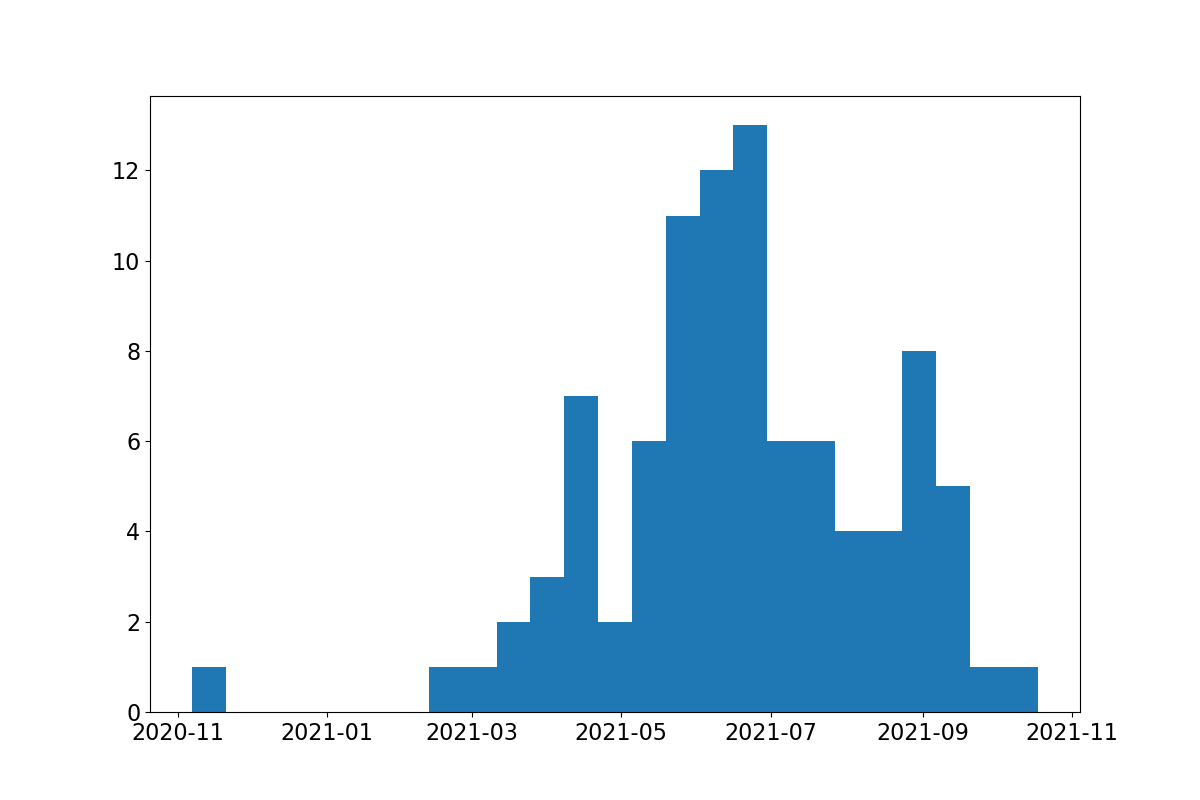

In [91]:
plt.figure()
plt.hist(allEqualDates,bins=25)

In [85]:
# plt.figure()

# pf.plotMean(curDates,curCaseNew,plt.gca())
# plt.tight_layout()

In [86]:
changeDate = np.datetime64('2021-10-01')
changeIndex = np.where(curDates==changeDate)[0][0]
reInf = curCase-curCaseNew 

popCount = getPopCount(curKom)

caseBefore = int(np.cumsum(curCase)[changeIndex])

caseTot = int(np.sum(curCase))
caseTotNew = int(np.sum(curCaseNew))

caseAfter = int(caseTot-caseBefore)
caseAfterNew = int(caseTotNew-caseBefore)
caseAfterAll = curCase
reTot = int(np.sum(reInf))
caseAfterNew
print(curKom)
print(f'Befolkning: {popCount}')
print(changeDate)
print(f'Inficeret før: {caseBefore}, svarende til {100*caseBefore/popCount:2.1f} % af befolkningen')
print(f'Inficeret efter: {caseAfter}, svarende til {100*caseAfter/popCount:2.1f} % af befolkningen')

print(f'Reinfektioner: {reTot}')

print(f'Andel, blandt før : {reTot}/{caseBefore} = {100*reTot/caseBefore:2.1f}%')
print(f'Andel, blandt alle: {caseAfterNew}/{popCount-caseBefore} = {100*(caseAfterNew)/(popCount-caseBefore):2.1f}%')

København
Befolkning: 641714
2021-10-01
Inficeret før: 67555, svarende til 10.5 % af befolkningen
Inficeret efter: 285706, svarende til 44.5 % af befolkningen
Reinfektioner: 26947
Andel, blandt før : 26947/67555 = 39.9%
Andel, blandt alle: 258759/574159 = 45.1%


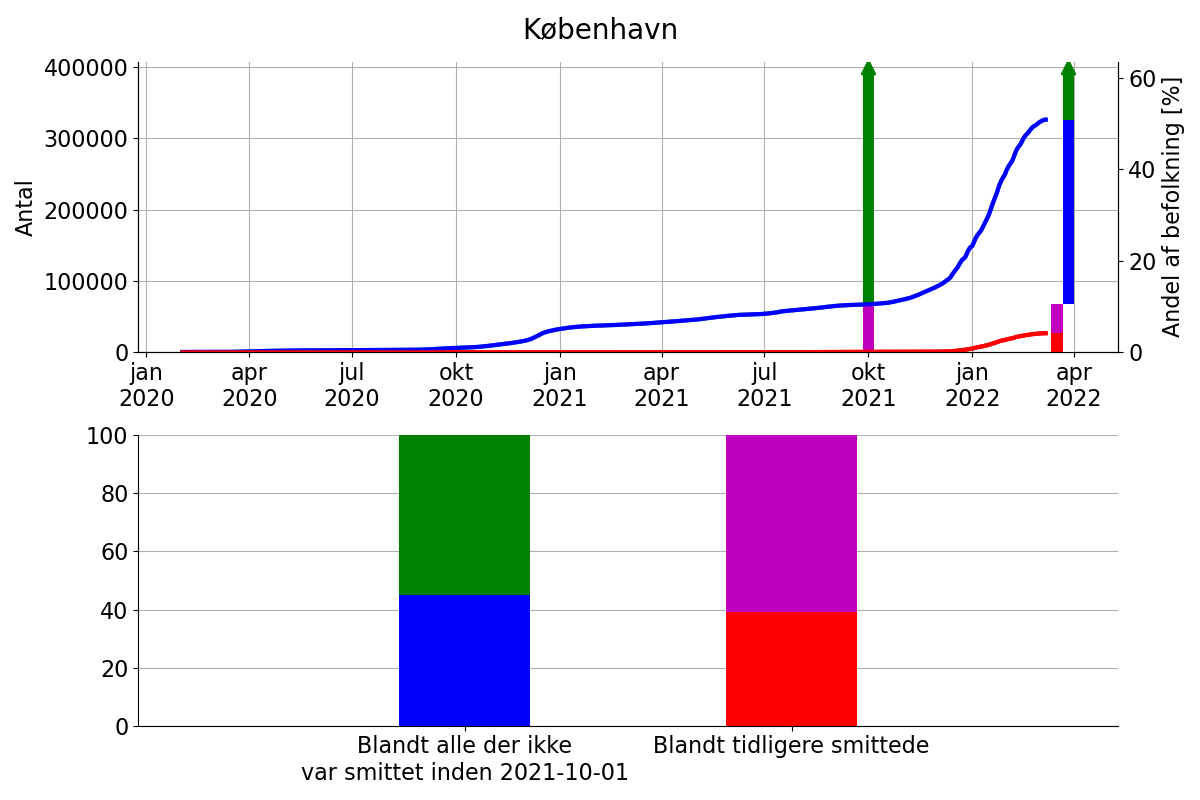

In [46]:

# fig,ax1 = plt.subplots()
fig,(ax1,ax2) = plt.subplots(2,1)
# fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15)) 


ax1.plot(curDates,np.cumsum(curCaseNew))
ax1_2 = ax1.twinx()

ratioBefore = 100*caseBefore/popCount

# ax1_2.plot([changeDate,curDates.values[-1]],[100*caseBefore/popCount,100*caseBefore/popCount],'k:')
ax1_2.plot(curDates,100*np.cumsum(curCaseNew)/popCount,'b',label='Nye smittede')


reInfPost = np.cumsum(reInf) - np.cumsum(reInf)[changeIndex]
ax1.plot(curDates,reInfPost,label=f'Reinfektioner siden {changeDate}',color='r')
# ax2_2 = ax2.twinx()
ax1_2.plot(curDates,100*reInfPost/popCount,color='r')

curMax = np.sum(curCaseNew)

barWidth = np.timedelta64(10,'D')
ax1_2.plot([changeDate,changeDate],[1+ ratioBefore + 100*curMax/popCount,1 + ratioBefore + 100*curMax/popCount],'g^')
ax1_2.bar(changeDate,ratioBefore + 100*curMax/popCount,width=barWidth,color='g')
# ax1_2.bar(changeDate,100,width=barWidth,color='g')
ax1_2.bar(changeDate,ratioBefore,width=barWidth,color='m')

lastDate = curDates.values[-1]


ax1_2.plot([lastDate+barWidth+barWidth,lastDate+barWidth+barWidth],[1+ ratioBefore + 100*curMax/popCount,1 + ratioBefore + 100*curMax/popCount],'g^')
ax1_2.bar(lastDate+barWidth+barWidth,ratioBefore + 100*curMax/popCount,width=barWidth,color='g')
ax1_2.bar(lastDate+barWidth+barWidth,100*np.sum(curCaseNew)/popCount,width=barWidth,color='b')

ax1_2.bar(lastDate+barWidth,ratioBefore,width=barWidth,color='m')
ax1_2.bar(lastDate+barWidth,100*reInfPost.values[-1]/popCount,width=barWidth,color='r')
ax1_2.bar(lastDate+barWidth+barWidth,ratioBefore,width=barWidth,color='w')




ax1_2.set_ylabel('Andel af befolkning [%]')
ax1.set_ylabel('Antal')

ax2.bar(0,100,label=f'Alle der var negative inden {changeDate}',color='g',width=0.2)
ax2.bar(0,100*caseAfterNew/(popCount-caseBefore),color='b',width=0.2)

ax2.bar(0.5,100,color='m',width=0.2)
ax2.bar(0.5,100*reInfPost.values[-1]/caseBefore,color='r',width=0.2)

ax2.set_xlim([-0.5,1])
ax2.set_ylim([0,100])

ax2.set_xticks([0,0.5])
ax2.set_xticklabels([f'Blandt alle der ikke\nvar smittet inden {changeDate}','Blandt tidligere smittede'])

ax2.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False) 
ax1.spines['top'].set_visible(False) 
ax1_2.spines['top'].set_visible(False) 

# ax1.axvline(changeDate,color='k',linestyle='--')

ax1.set_ylim(bottom=0,top=curMax*1.25)
ax1_2.set_ylim(bottom=0,top=100*curMax*1.25/popCount)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.grid() 
ax2.grid()
ax2.set_axisbelow(True)

fig.suptitle(curKom,fontsize=20)
# ax1.set_title(curKom)

fig.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'ReinfektionAndelForklaring')

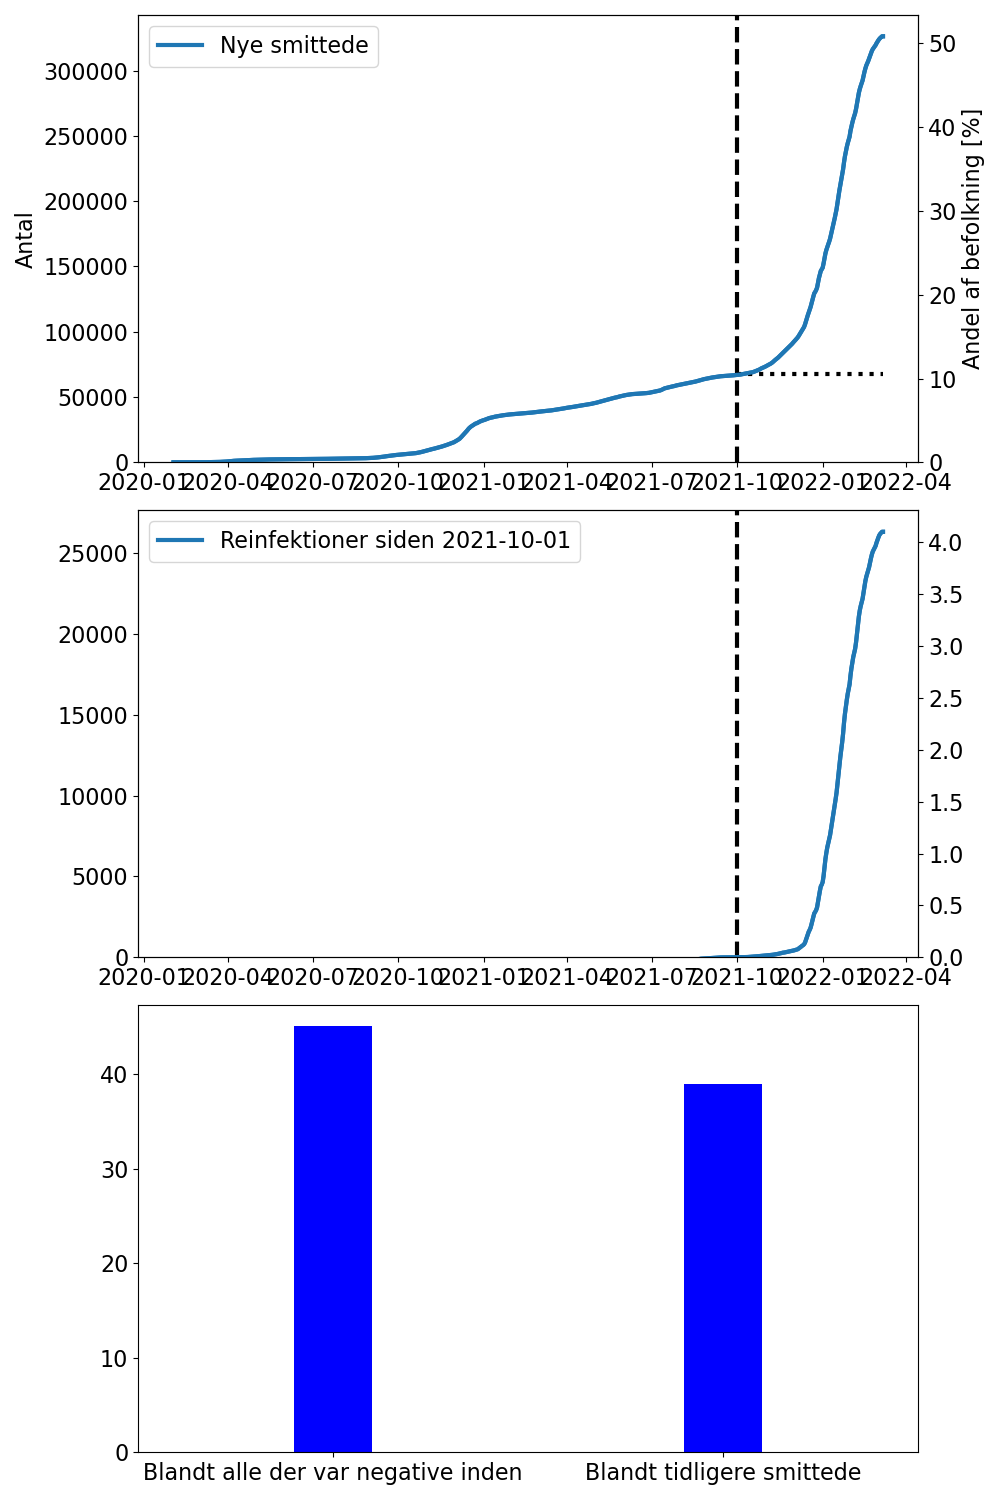

In [31]:
# Forklarende illustration

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15)) 

ax1.axvline(changeDate,color='k',linestyle='--')
ax2.axvline(changeDate,color='k',linestyle='--')

ax1.plot(curDates,np.cumsum(curCaseNew))
ax1_2 = ax1.twinx()
ax1_2.plot([changeDate,curDates.values[-1]],[100*caseBefore/popCount,100*caseBefore/popCount],'k:')
ax1_2.plot(curDates,100*np.cumsum(curCaseNew)/popCount,label='Nye smittede')

reInfPost = np.cumsum(reInf) - np.cumsum(reInf)[changeIndex]
# ax2.plot(curDates,np.cumsum(reInf))
ax2.plot(curDates,reInfPost,label=f'Reinfektioner siden {changeDate}')
ax2_2 = ax2.twinx()
ax2_2.plot(curDates,100*reInfPost/popCount)


ax1.set_ylim(bottom=0)
ax1_2.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax2_2.set_ylim(bottom=0)

ax1_2.legend() 
ax2.legend()

ax1_2.set_ylabel('Andel af befolkning [%]')
ax1.set_ylabel('Antal')

# ax3.bar(0,100,label=f'Alle der var negative inden {changeDate}',color='k',width=0.2)
ax3.bar(0,100*caseAfterNew/(popCount-caseBefore),color='b',width=0.2)

# ax3.bar(1,100,color='k',width=0.2)
ax3.bar(1,100*reInfPost.values[-1]/caseBefore,color='b',width=0.2)

ax3.set_xlim([-0.5,1.5])

ax3.set_xticks([0,1])
ax3.set_xticklabels(['Blandt alle der var negative inden','Blandt tidligere smittede'])

# ax1.plot(curDates,np.cumsum(reInf))
plt.tight_layout()

(0.0, 370924.05)

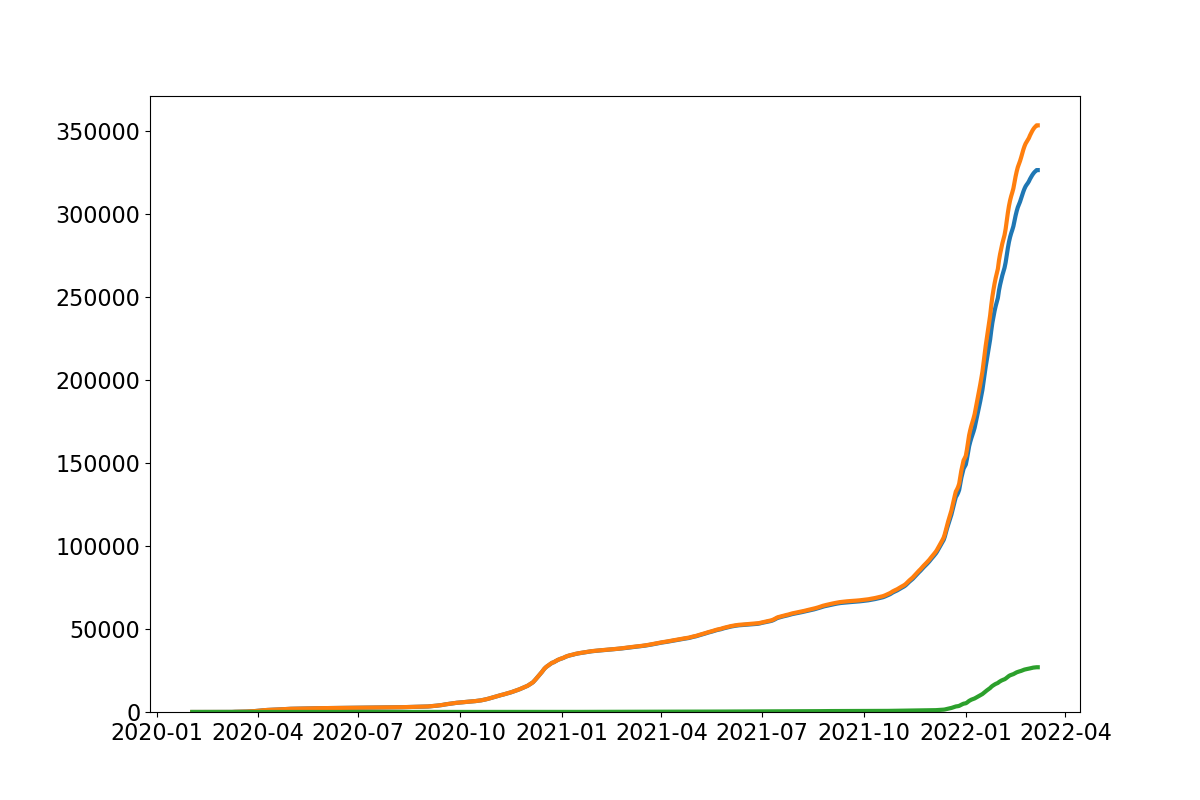

In [ ]:
plt.figure()
plt.plot(curDates,np.cumsum(curCaseNew))
plt.plot(curDates,np.cumsum(curCase))
plt.plot(curDates,np.cumsum(reInf))

plt.ylim(bottom=0)

In [ ]:
26/93
320/550

26/67
320/((93+550)-67)

0.5555555555555556